## Constraining range of parameters

We construct a **bounding box** to gradually shrink the ranges of the parameters and observe the resulting success rate of the samples within the box. Shifting the box can help us explore ranges that are not centered around a nominal value of parameter and capture meaningful interactions. 

In [1]:
using Pkg
Pkg.activate("../Project.toml")

 Activating environment at `~/Desktop/Research/SWQUProject/MaxProAnalysis/Project.toml`


In [2]:
using Random

In [3]:
rng = MersenneTwister(12345);

In [4]:
using CSV
using DataFrames
using Printf
using IterTools
using Plots
gr()

Plots.GRBackend()

## Rough Implementation for Bounding Box

In [5]:
B = randn(5, 3)

5×3 Array{Float64,2}:
 -1.1831    -0.0672299   0.0852185
  1.1424    -0.752924    0.290024
  0.589941  -0.958738    0.805
 -0.478759   1.21635    -0.537672
  0.800709   0.289094   -0.911636

In [6]:
lbb = [0.3, -0.5, -0.4]
ubb = [1.2, 1.5, 2.2]

3-element Array{Float64,1}:
 1.2
 1.5
 2.2

In [7]:
x = []
for j in 1:size(A, 2)
    push!(x, findall(lbb[j] .< B[:, j] .< ubb[j]))
end

LoadError: [91mUndefVarError: A not defined[39m

In [8]:
x

Any[]

In [42]:
# commonElements = intersect(x...)

## Load data and find success rate for each bounding box

In [10]:
Xdata = CSV.read("../Outputs/MaxPro_inputs_outputs.txt", DataFrame);
typeof(Xdata)

DataFrame

In [11]:
first(Xdata, 5)

,BrFactor_ADAPT,nChromoSi_AWSoM,PoyntingFluxPerBSi,LperpTimesSqrtBSi,StochasticExponent
,Float64,Float64,Float64,Float64,Float64
1,0.545294,1.12941e18,6.39216e5,2.13309e5,0.29
2,0.555882,4.98824e18,7.76471e5,2.45074e5,0.220588
3,0.566471,2.02353e18,8.66667e5,1.86838e5,0.31
4,0.577059,4.0e18,3.84314e5,108750.0,0.295882
5,0.587647,2.54118e18,4.5098e5,1.48456e5,0.205294


In [43]:
names(Xdata)[1:7]

7-element Array{String,1}:
 "BrFactor_ADAPT"
 "nChromoSi_AWSoM"
 "PoyntingFluxPerBSi"
 "LperpTimesSqrtBSi"
 "StochasticExponent"
 "BrMin"
 "rMinWaveReflection"

In [12]:
A = Matrix(Xdata[:, 1:7])'

7×200 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.545294    0.555882    0.566471    …  2.64176         2.65235
 1.12941e18  4.98824e18  2.02353e18     9.17647e17      3.22353e18
 6.39216e5   7.76471e5   8.66667e5      1.08235e6       3.56863e5
 2.13309e5   2.45074e5   1.86838e5      2.25221e5   41250.0
 0.29        0.220588    0.31           0.248824        0.127647
 5.47794     7.1201      8.00245     …  9.47304         7.6348
 1.10147     1.09461     1.075          1.16127         1.01912

In [13]:
failed = Xdata[!, end] .== 0
successful = Xdata[!, end] .== 1
println("Number of failed runs = $(sum(failed))")
println("Number of successful runs = $(sum(successful))")

Number of failed runs = 125
Number of successful runs = 75


In [14]:
# give upper and lower bounds of params in order of columns
lowerBounds = [0.54, 2e17, 0.3e6, 0.3e5, 0.1, 5, 1]
upperBounds = [2.7, 5e18, 1.1e6, 3e5, 0.34, 10, 1.2]
diffBounds = upperBounds - lowerBounds

7-element Array{Float64,1}:
      2.16
      4.8e18
 800000.0
 270000.0
      0.24000000000000002
      5.0
      0.19999999999999996

In [15]:
box_scale = 0.9
lowerBoundsScaled = lowerBounds + 0.5 * (1 - box_scale) * diffBounds 
upperBoundsScaled = upperBounds - 0.5 * (1 - box_scale) * diffBounds;

In [16]:
function findBoundedSamples(A, box_scale)
    lowerBoundsScaled = lowerBounds + 0.5 * (1 - box_scale) * diffBounds 
    upperBoundsScaled = upperBounds - 0.5 * (1 - box_scale) * diffBounds;
    boundedSamplesByRow = []
    for i in 1:size(A, 1)
        push!(boundedSamplesByRow, findall(lowerBoundsScaled[i] .< A[i, :] .< upperBoundsScaled[i]))
    end
    return intersect(boundedSamplesByRow...)
#     return union(boundedSamplesByRow...)
end

findBoundedSamples (generic function with 1 method)

In [80]:
## encode for non-centred nominal values
nominal_values = [1.0, 2e17, 1e6, 1.5e5, 0.21, 7.5, 1.0]
# 7.5 is arbitrarily set, rest are taken from AWSoM inputs Google Doc

[lowerBounds nominal_values upperBounds diffBounds]

7×4 Array{Float64,2}:
      0.54         1.0          2.7          2.16
      2.0e17       2.0e17       5.0e18       4.8e18
 300000.0          1.0e6        1.1e6   800000.0
  30000.0     150000.0     300000.0     270000.0
      0.1          0.21         0.34         0.24
      5.0          7.5         10.0          5.0
      1.0          1.0          1.2          0.2

In [88]:
function findBoundedSamplesNC(A, box_scale)
    lbCentered = lowerBounds + 0.5 * (1 - box_scale) * diffBounds 
    ubCentered = upperBounds - 0.5 * (1 - box_scale) * diffBounds;
    shift = nominal_values - (0.5 * diffBounds + lowerBounds)
    lbShifted = lbCentered + shift
    ubShifted = ubCentered + shift
#     return lbShifted, ubShifted
    boundedSamplesByRow = []
    for i in 1:size(A, 1)
        push!(boundedSamplesByRow, findall(lbShifted[i] .< A[i, :] .< ubShifted[i]))
    end
    return intersect(boundedSamplesByRow...)
end

findBoundedSamplesNC (generic function with 1 method)

In [89]:
# lbShifted, ubShifted = findBoundedSamplesNC(A, 0.9)
# [lbShifted ubShifted (ubShifted - lbShifted) ./ (upperBounds - lowerBounds)]

Conceptually, the above means drawing a box around the nominal point, covering say, 90% of the total volume of an n-dimensional hypercube. We draw the **90%** and **80%** bounding boxes below for **just 2 parameters** to illustrate the exercise.

Once the box is constructed, we:
1. Identify samples that lie within box
2. Calculate success rate within those samples
3. (To be implemented) Shift the box around (find non centered box) with highest success rate. The outcome represents how we should constrain the parameter ranges. 

In [17]:
# Define a function to calculate the bounding box. 
function draw2DBoundingBox(box_scale, ub, lb)
    
    diffb = ub - lb
    lbScaled = lb + 0.5 * (1 - box_scale) * diffb 
    ubScaled = ub - 0.5 * (1 - box_scale) * diffb;
    
    w = ubScaled[1] - lbScaled[1]
    h = ubScaled[2] - lbScaled[2]
    
    return Shape(lbScaled[1] .+ [0,w,w,0], lbScaled[2] .+ [0,0,h,h]) 
end

draw2DBoundingBox (generic function with 1 method)

In [74]:
cur_colors = palette(:default);

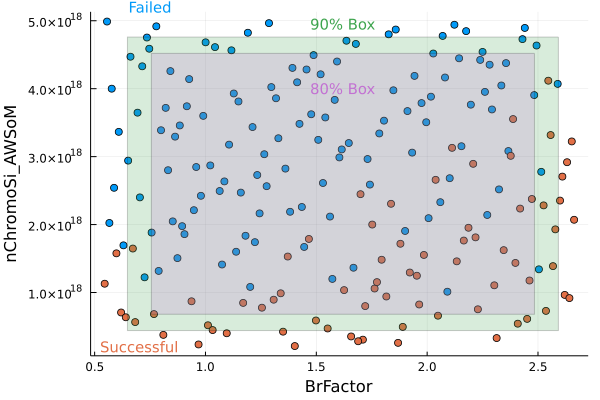

In [77]:
scatter(A[1, failed], A[2, failed], 
        xlabel = "BrFactor", 
        ylabel = "nChromoSi_AWSoM"
        )
scatter!(A[1, successful], A[2, successful],  
        )
annotate!(0.75, 5.2e18, text("Failed", cur_colors[1], :above, 10, :bold))
annotate!(0.7, 0.2e18, text("Successful", cur_colors[2], :below, 10, :bold))
annotate!(1.62, 4.95e18, text("90% Box", cur_colors[3], :above, 10, :bold))
annotate!(1.62, 4.0e18, text("80% Box", cur_colors[4], :below, 10, :bold))
plot!(draw2DBoundingBox(0.9, lowerBounds[1:2], upperBounds[1:2]), opacity = 0.2)
plot!(draw2DBoundingBox(0.8, lowerBounds[1:2], upperBounds[1:2]), opacity = 0.2)
plot!(legend=:false)

In [101]:
# Now run the above in a loop for different box scales and plot out the success ratio
success_ratios = []
numberOfSuccesses = []
numberOfSamples = []
box_scales = 0.99:-0.01:0.80
for scale in box_scales
#     boundedSamplesIdx =  findBoundedSamples(A, scale)
    boundedSamplesIdx = findBoundedSamplesNC(A, scale)
    success_rate = sum(successful[boundedSamplesIdx])
    push!(numberOfSuccesses, success_rate)
#     push!(success_ratios, 100 * success_rate / sum(successful))
    push!(numberOfSamples, length(boundedSamplesIdx))
    push!(success_ratios, 100 * success_rate / length(boundedSamplesIdx))
end

In [102]:
boundedSamples = findBoundedSamples(A, 0.99)
sum(successful[boundedSamples])
# length(boundedSamples)

70

In [103]:
70 / 188

0.3723404255319149

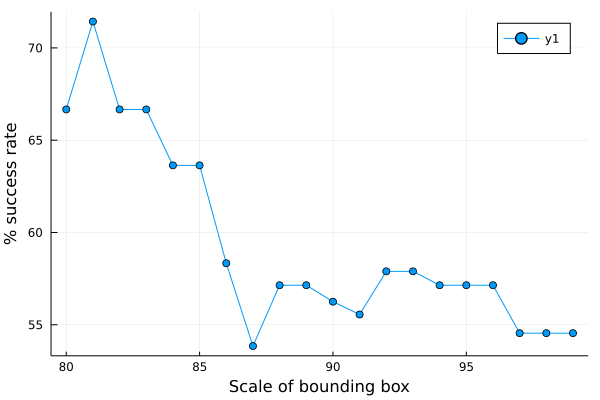

In [104]:
p2 = plot(100 * box_scales, success_ratios, marker=:circle)
plot!(xlabel = "Scale of bounding box")
plot!(ylabel = "% success rate")
plot!(legend=:topright)

In [95]:
tt = DataFrame(:boxScales => box_scales,
               :nSamples => numberOfSamples, 
               :nSuccesses => numberOfSuccesses, 
               :fractionSuccessful => success_ratios)

,boxScales,nSamples,nSuccesses,fractionSuccessful
,Float64,Any,Any,Any
1,0.99,22,12,54.5455
2,0.98,22,12,54.5455
3,0.97,22,12,54.5455
4,0.96,21,12,57.1429
5,0.95,21,12,57.1429
6,0.94,21,12,57.1429
7,0.93,19,11,57.8947
8,0.92,19,11,57.8947
9,0.91,18,10,55.5556


In [96]:
success_ratios = []
numberOfSuccesses = []
numberOfSamples = []
box_scales = 0.99:-0.01:0.80
for scale in box_scales
    boundedSamplesIdx =  findBoundedSamples(A, scale)
#     boundedSamplesIdx = findBoundedSamplesNC(A, scale)
    success_rate = sum(successful[boundedSamplesIdx])
    push!(numberOfSuccesses, success_rate)
#     push!(success_ratios, 100 * success_rate / sum(successful))
    push!(numberOfSamples, length(boundedSamplesIdx))
    push!(success_ratios, 100 * success_rate / length(boundedSamplesIdx))
end

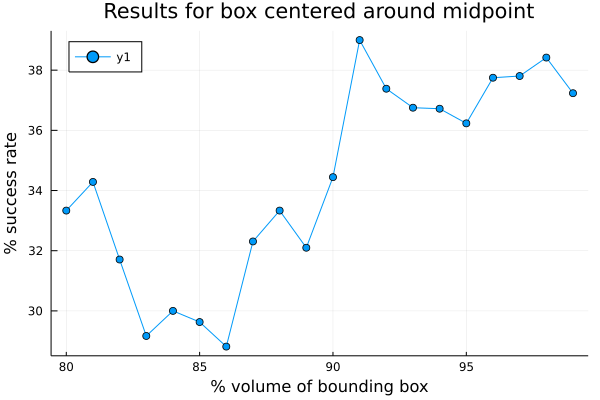

In [98]:
p3 = plot(100 * box_scales, success_ratios, marker=:circle)
plot!(xlabel = "% volume of bounding box")
plot!(ylabel = "% success rate")
plot!(legend=:topleft)
plot!(title="Results for box centered around midpoint")

In [99]:
ttCentered = DataFrame(:boxScales => box_scales,
               :nSamples => numberOfSamples, 
               :nSuccesses => numberOfSuccesses, 
               :fractionSuccessful => success_ratios)

,boxScales,nSamples,nSuccesses,fractionSuccessful
,Float64,Any,Any,Any
1,0.99,188,70,37.234
2,0.98,177,68,38.4181
3,0.97,164,62,37.8049
4,0.96,151,57,37.7483
5,0.95,138,50,36.2319
6,0.94,128,47,36.7188
7,0.93,117,43,36.7521
8,0.92,107,40,37.3832
9,0.91,100,39,39.0


## Implement shifts in box based on regression model